# Update OISST Anomalies

**Objective: Bring in new year(s) of OISST Data, get all the related products without re-calculating the climatologies etc.**

## Product 1: Sea Surface Temperature Anomalies

NOTE: As of this date 9/10/2020, must be done outside of docker environment. So to execute this code, exit the docker environment with `make down` then proceed to activate the `py36` conda environment and open `Jupyter lab` from the terminal. From there we proceed to updating OISST products.


**Updated Products:**
 * Daily OISST Anomalies (from 1982 to 2011 climatology)

In [1]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import geopandas as gpd
import regionmask

# Root paths
root_locations = {"local" : "/Users/akemberling/Box/",
                  "docker" : "/Users/akemberling/Box/"}

# Set the workspace - local/ docker
workspace = "local"
box_root = root_locations[workspace]
print(f"Working via {workspace} directory at: {box_root}")

#ensure we're in correct directory - remember, not docker volumes
os.chdir(f"{box_root}RES_Data")

Working via local directory at: /Users/akemberling/Box/


## Set Update Parameters

This notebook is organized to take a handful parameters in the beginning which will guide what data is updated and how it is appended to the full products.

In [2]:
# Specify year range to update
yr_min = 2020
yr_max = 2020
update_yrs = range(yr_min, yr_max + 1)
print(update_yrs)

range(2020, 2021)


## Load the data to append

As a first step, the data we wish to update and extend our products with needs to be brought into the environment. Newer observations can be downloaded directly from: [NOAA Physical Sciences Laboratory](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html)

These files (organized by year) are the same formatting as the other years that have been downloaded. Alternatively, OISSTv2 data can be accessed via [https://www.ncdc.noaa.gov/oisst/data-access](https://www.ncdc.noaa.gov/oisst/data-access)

In [3]:
# Append Global netcdf paths together
fpaths = []
for yr in update_yrs:
    fpaths.append(f'{box_root}RES_Data/OISST/oisst_mainstays/annual_observations/sst.day.mean.{yr}.v2.nc')

# Lazy-load the data itself using xr.open_mfdataset
oisst = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = False)
oisst


# Add modified ordinal day, for day-to-day calculation and leapyear adjustment
not_leap_year        = ~oisst.indexes['time'].is_leap_year
march_or_later       = oisst.time.dt.month >= 3
ordinal_day          = oisst.time.dt.dayofyear
modified_ordinal_day = ordinal_day + (not_leap_year & march_or_later)

# Assign MOD coordinate
oisst = oisst.assign_coords(MOD = modified_ordinal_day)
oisst

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 366)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
    MOD      (time) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(366, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

## Load Global Climatology

The global climatology is generated in the notebook: `01_OISST_calc_climatology`. The years covered are 1982-2011, the extent is global, and the resolution is the same as OISSTv2 data at 1/4 degree cells.

In [4]:
# Load Global Climatology
#oisst_clim = xr.open_dataset('~/Box/NSF OKN Demo Data/oisst/daily_climatologies/daily_clims_1982to2011.nc')
oisst_clim = xr.open_dataset('~/Box/RES_Data/OISST/oisst_mainstays/daily_climatologies/daily_clims_1982to2011.nc')
oisst_clim

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, modified_ordinal_day: 366)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Data variables:
    sst                   (modified_ordinal_day, lat, lon) float32 ...

# Calculate Global Anomalies

## How: 
**GroupBy "time": split-apply-combine**

So from the full daily set, we want to group by the time to split out each day. Then use the modified ordinal day to subtract the matching climatology.

To help do this we define the function that will take a daily slice of the observed sst, and subtract it by its matching climatology:

In [5]:
# Input is a xarray dataset grouped on the daily time step coordinate
# paired with the climatology
# selects the "modified_ordinal_day" from the climatology that matches "MOD"

def calc_anom(daily_sst):
    return daily_sst - oisst_clim.sel(modified_ordinal_day = daily_sst["MOD"])

## Calculate daily anomalies

In [6]:
daily_anoms = oisst.groupby('time').map(calc_anom)

## Plot test

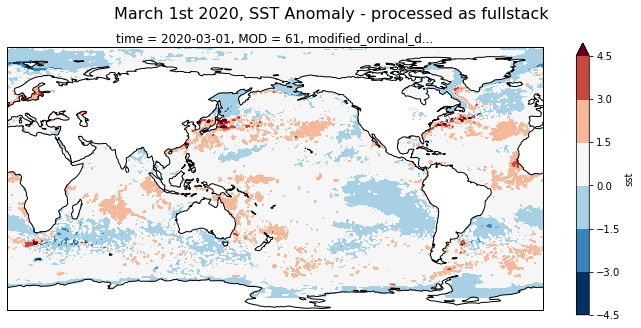

In [7]:
import cartopy.crs as ccrs
fig = plt.figure(figsize=[12,5])

ax = fig.add_subplot(111, projection = ccrs.PlateCarree(central_longitude=180))
fig.suptitle('March 1st 2020, SST Anomaly - processed as fullstack', fontsize=16)

daily_anoms.sel(time = '2020-03-01')['sst'].plot.contourf(
    ax=ax,
    levels=np.arange(-4.5, 6, 1.5),
    extend='max',
    transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

In [8]:
# check format one last time
daily_anoms

,Array,Chunk
Bytes,1.52 GB,4.15 MB
Shape,"(366, 720, 1440)","(1, 720, 1440)"
Count,1832 Tasks,366 Chunks
Type,float32,numpy.ndarray


## Save, close netcdf files

In [9]:
#Export as annual netcdf files
for year, group in daily_anoms.groupby('time.year'):
    group.to_netcdf(f'{box_root}RES_Data/OISST/oisst_mainstays/annual_anomalies/daily_anoms_{year}.nc')
    print(f"Saving anomaly year: {year}")

Saving anomaly year(s): 2020


In [ ]:
# Close netcdf files
oisst.close()
daily_anoms.close()
oisst_clim.close()